## to do

random forest

https://github.com/dgriffiths3/ml_segmentation



## Read dataset

In [1]:
import numpy as np
import os
from tensorflow.keras import layers
import keras
from PIL import Image
import numpy as np
import copy
import matplotlib.pyplot as plt
import tensorflow as tf

import PIL
from PIL import ImageOps
from PIL import Image 
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm


### read variables in mmap mode to save memory 

In [2]:
input_dat = np.load(os.path.join('../data_fin/train_input_dat.npy'), mmap_mode='r')
target_dat = np.load(os.path.join('../data_fin/train_target_dat.npy'), mmap_mode='r')

In [3]:
train_input_dat=input_dat[1500:,:,:,:]
train_target_dat=target_dat[1500:,:,:,:]

val_input_dat=input_dat[:1500,:,:,:]
val_target_dat=target_dat[:1500,:,:,:]



## What classes are in the dataset

### Entire dataset

<BarContainer object of 9 artists>

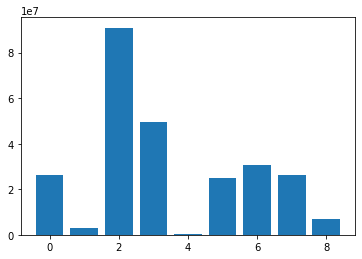

In [4]:
flat=np.argmax(target_dat, axis=-1).flatten()
unique, counts = np.unique(flat, return_counts=True)
plt.bar(unique, counts)

### Traing dataset

<BarContainer object of 9 artists>

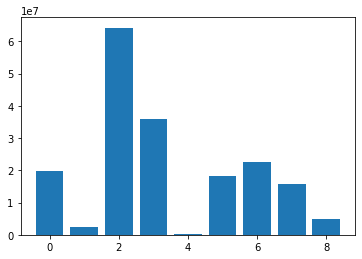

In [5]:
flat=np.argmax(train_target_dat, axis=-1).flatten()
unique, counts = np.unique(flat, return_counts=True)
plt.bar(unique, counts)

### Testing dataset

<BarContainer object of 9 artists>

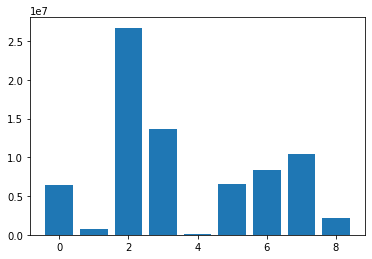

In [6]:
flat=np.argmax(val_target_dat, axis=-1).flatten()
unique, counts = np.unique(flat, return_counts=True)
plt.bar(unique, counts)

## Sample image and mask

(224, 224, 3)


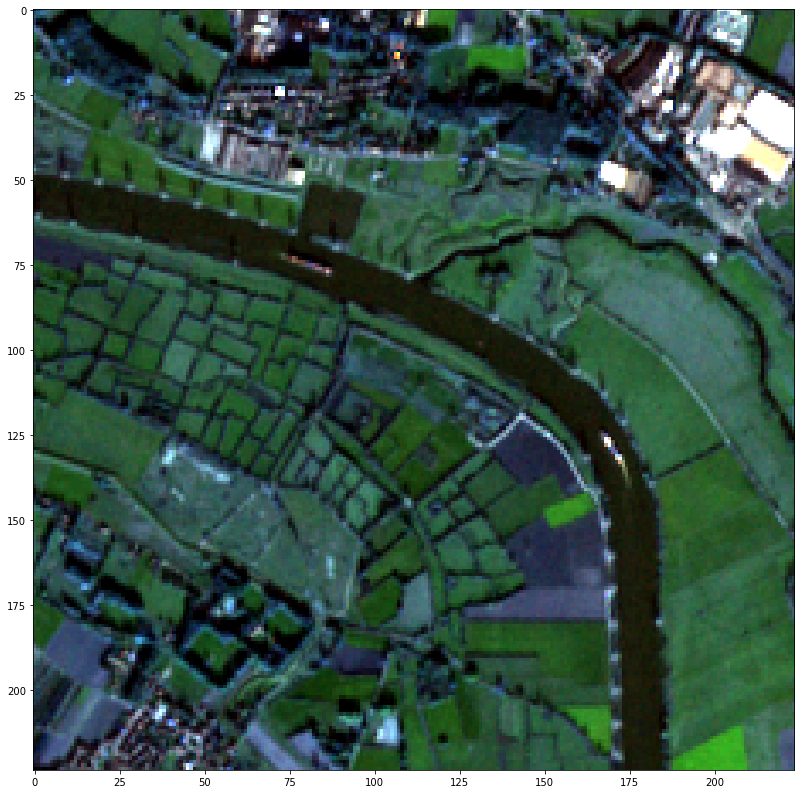

/home/bd/anaconda3/envs/tf-gpu4/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


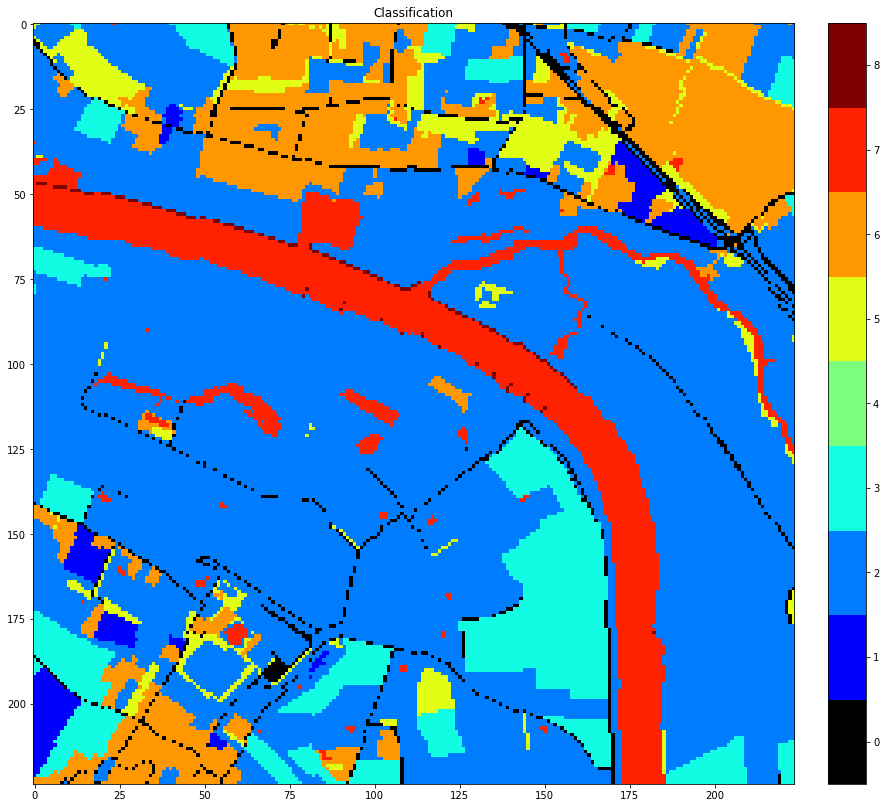

In [7]:

def Setcmap(D, inv=1):
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (.0, .0, .0, 1.0)
    if inv:
        cmap = LinearSegmentedColormap.from_list('Custom_cmap', cmaplist, cmap.N)
    else:
        cmap = LinearSegmentedColormap.from_list('Custom_cmap', cmaplist[::-1], cmap.N)
    plt.register_cmap(name='Custom_cmap', cmap=cmap)
    bounds = np.linspace(0, D, D+1)
    norm = BoundaryNorm(bounds, cmap.N)
    return cmap, norm



def display_image(I):
    print(I.shape)
    tmp = np.zeros((I.shape[0], I.shape[1], 3), dtype=np.uint8)
    for q in range(3):
        a = copy.copy(I[:,:,q]) 
        D = a>0
        prc = np.percentile(a[D],[1,99])
        tmp[:,:,2-q] = np.digitize(a,np.linspace(prc[0],prc[1],255))*D
    plt.imshow(tmp)
    f = plt.gcf()
    f.set_size_inches(15, 14)
    plt.show()
    
def display_target(I):
    cmap, norm = Setcmap(9)
    Class=np.argmax(I, axis=-1)
    im = plt.imshow(Class, cmap=cmap, norm=norm, vmin=0, vmax=9)
    plt.title('Classification')
    plt.set_cmap(cmap)
    cb = plt.colorbar(im, fraction=0.046, pad=0.04, ticks=range(9))
    cb.set_ticks(np.arange(9) + .5)
    cb.set_ticklabels(np.arange(9))
    plt.gcf().set_size_inches(15, 14)
    plt.show()
    
    
    
    
# Display results for validation image #10
i = 78


# Display input image
display_image(val_input_dat[i])

# Display ground-truth target mask
display_target(val_target_dat[i])
    

## Perpare U-Net Xception-style model

In [8]:

img_size = (224, 224)
num_classes = 9
batch_size = 32

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
num_classes=9
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

https://keras.io/api/metrics/segmentation_metrics/#image-segmentation-metrics

## Train

In [11]:
#Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
  
#  

model.compile(
  optimizer='rmsprop',
  loss='categorical_crossentropy',
  ##metrics=[tf.keras.metrics.CategoricalCrossentropy()]
  metrics='acc'
)

model_name='unet-2Mv007-acc.h5'

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='../weights/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

# Train the model, doing validation at the end of each epoch.
epochs = 200
history=model.fit(train_input_dat, train_target_dat, epochs=epochs, 
                  validation_data=(val_input_dat,val_target_dat), 
       
                  callbacks=callbacks)

Epoch 1/200
115/115 [==============================] - 38s 332ms/step - loss: 0.9026 - acc: 0.6853 - val_loss: 0.9301 - val_acc: 0.6960
Epoch 2/200
115/115 [==============================] - 38s 328ms/step - loss: 0.8767 - acc: 0.6949 - val_loss: 0.9340 - val_acc: 0.6943
Epoch 3/200
115/115 [==============================] - 37s 325ms/step - loss: 0.8650 - acc: 0.6972 - val_loss: 0.9165 - val_acc: 0.6967
Epoch 4/200
115/115 [==============================] - 37s 326ms/step - loss: 0.8514 - acc: 0.7022 - val_loss: 0.9158 - val_acc: 0.7006
Epoch 5/200
115/115 [==============================] - 37s 326ms/step - loss: 0.8344 - acc: 0.7073 - val_loss: 0.9328 - val_acc: 0.6905
Epoch 6/200
115/115 [==============================] - 37s 325ms/step - loss: 0.8261 - acc: 0.7102 - val_loss: 0.9337 - val_acc: 0.6867
Epoch 7/200
115/115 [==============================] - 37s 326ms/step - loss: 0.8129 - acc: 0.7144 - val_loss: 0.9846 - val_acc: 0.6898
Epoch 8/200
115/115 [===========================

In [23]:
model.save('models/'+model_name)

In [12]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'models/'+model_name
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Evaluate model

## Visualizing model performance
### Let's plot the model accuracy and loss for the training and the validating set. Note that no random seed is specified for this notebook. For your notebook, there might be slight variance.

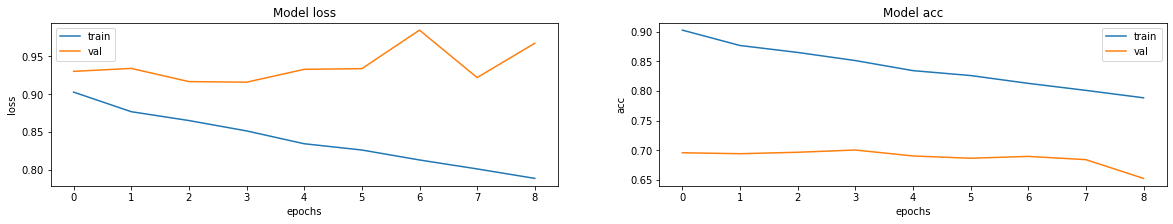

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'acc']):
    ax[i].plot(hist_df['loss'])
    ax[i].plot(hist_df["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [5]:

model = get_model(img_size, num_classes)
model.summary()

fnmodel = 'models/'+model_name
#fnmodel='../models/model5.h5'
model.load_weights(filepath = fnmodel)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 112, 112, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 112, 112, 32) 128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 112, 112, 32) 0           batch_normalization_15[0][0]     
_______________________________________________________________________________________

ValueError: Shapes (3, 3, 3, 32) and (32, 4, 3, 3) are incompatible

In [ ]:
#model_name='unet-2Mv002.h5'

## Confution matrix

https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

In [14]:
Y_pred = model.predict_generator((val_input_dat,val_target_dat), 1500 // batch_size+1)
y_pred= np.argmax(Y_pred, axis=3).flatten()
y= np.argmax(val_target_dat, axis=3).flatten()


Instructions for updating:
Please use Model.predict, which supports generators.


In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
target_names=['0','1','2','3','4','5','6','7','8']

cm = confusion_matrix(y, y_pred)


In [16]:
cm


array([[ 1074585,    77120,  2038951,   725763,        0,   940220,
         1454894,    86811,    43924],
       [  107574,   278501,   204021,   123627,        0,    29483,
           50025,     1304,       20],
       [ 3507765,   205290, 19020894,  2455659,        0,   569316,
          723335,   177052,    73938],
       [ 1754141,   356862,  2526457,  8766772,        0,    88947,
          142686,    56894,     6605],
       [    4738,        0,      720,        0,        0,      179,
           97385,      204,        4],
       [  255672,    27223,   862301,    84249,        0,  5014089,
          229343,    21004,    27915],
       [  974915,    75679,  1326184,   155548,        0,   227447,
         5588070,    36907,    10748],
       [  351784,    33014,  1031647,   165732,        0,   144032,
          237730,  8312566,   158277],
       [  168383,     8361,   272645,    21484,        0,   433068,
           89636,    75830,  1069851]])

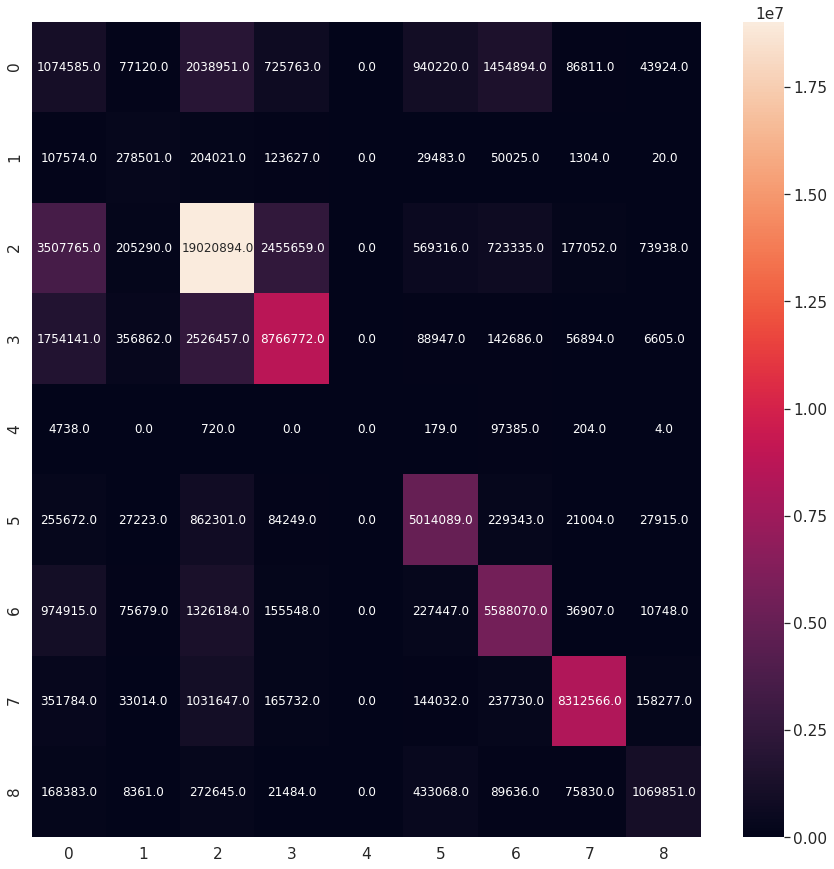

In [17]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, range(9), range(9))
plt.figure(figsize=(15,15))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True,fmt='.1f', annot_kws={"size": 12}) # font size

plt.show()

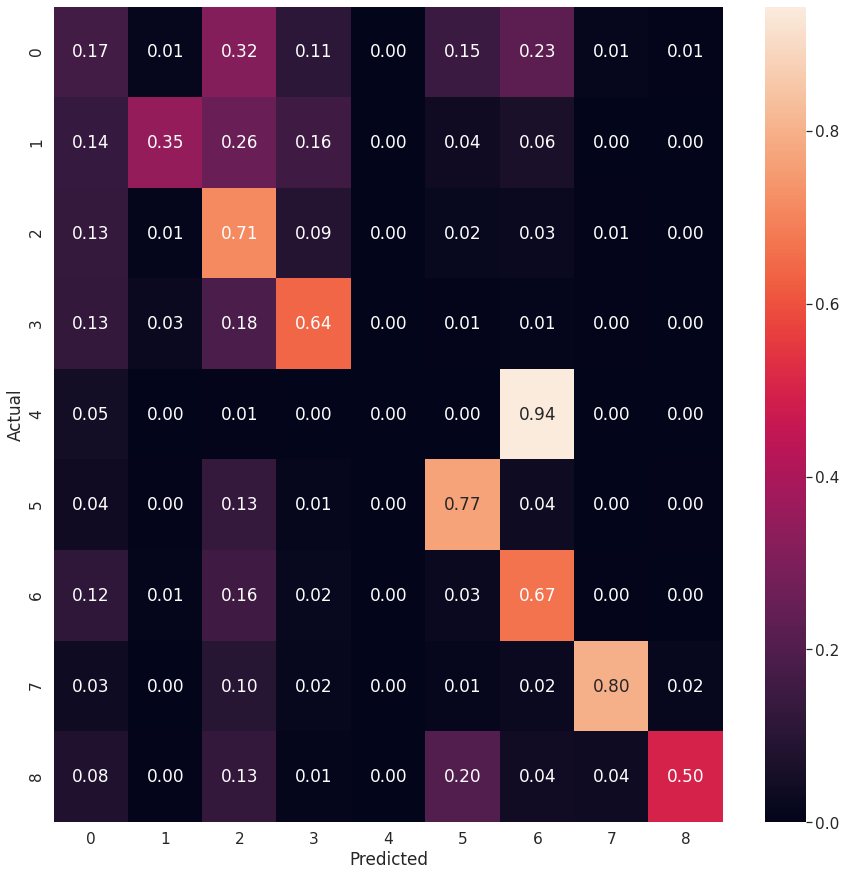

In [18]:
# Normalise
cmn = cm.astype('float') /cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Model Evaluate

## Visualize predictions

In [19]:
Y_pred.shape

(1500, 224, 224, 9)

(224, 224, 3)


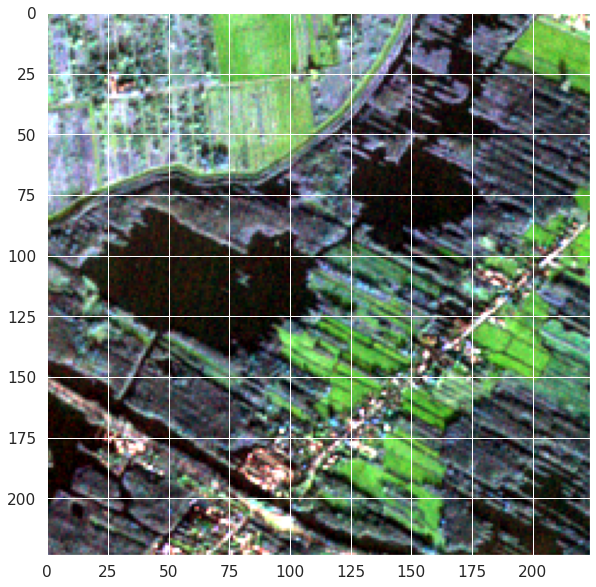

/home/bd/anaconda3/envs/tf-gpu4/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


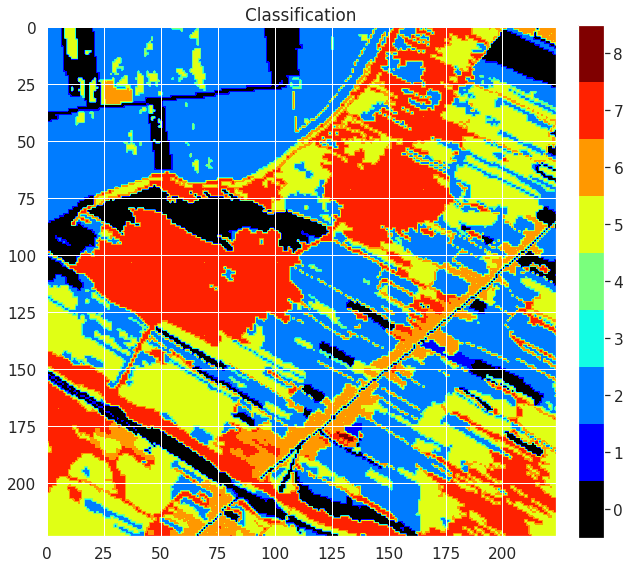

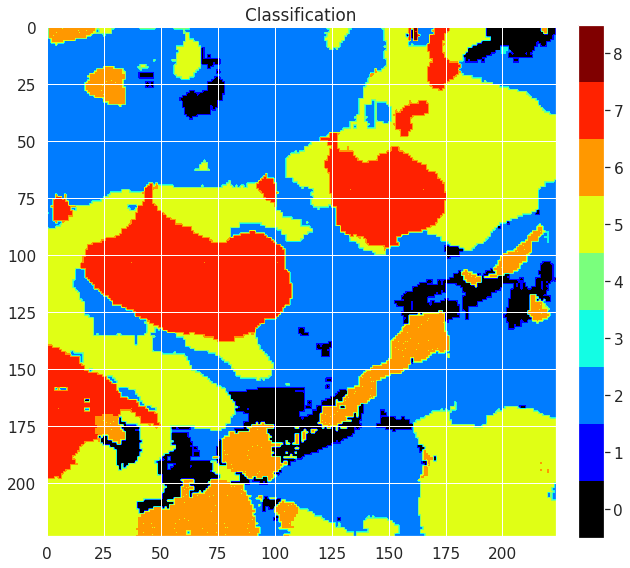

In [22]:
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
def Setcmap(D, inv=1):
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (.0, .0, .0, 1.0)
    if inv:
        cmap = LinearSegmentedColormap.from_list('Custom_cmap', cmaplist, cmap.N)
    else:
        cmap = LinearSegmentedColormap.from_list('Custom_cmap', cmaplist[::-1], cmap.N)
    plt.register_cmap(name='Custom_cmap', cmap=cmap)
    bounds = np.linspace(0, D, D+1)
    norm = BoundaryNorm(bounds, cmap.N)
    return cmap, norm



def display_image(I):
    print(I.shape)
    tmp = np.zeros((I.shape[0], I.shape[1], 3), dtype=np.uint8)
    for q in range(3):
        a = copy.copy(I[:,:,q]) 
        D = a>0
        prc = np.percentile(a[D],[1,99])
        tmp[:,:,2-q] = np.digitize(a,np.linspace(prc[0],prc[1],255))*D
    plt.imshow(tmp)
    f = plt.gcf()
    f.set_size_inches(10, 10)
    plt.show()
    
def display_target(I):
    cmap, norm = Setcmap(9)
    Class=np.argmax(I, axis=-1)
    im = plt.imshow(Class, cmap=cmap, norm=norm, vmin=0, vmax=9)
    plt.title('Classification')
    plt.set_cmap(cmap)
    cb = plt.colorbar(im, fraction=0.046, pad=0.04, ticks=range(9))
    cb.set_ticks(np.arange(9) + .5)
    cb.set_ticklabels(np.arange(9))
    plt.gcf().set_size_inches(10, 10)
    plt.show()
    
# Display results for validation image #10
i = 13


# Display input image
display_image(val_input_dat[i])

# Display ground-truth target mask
display_target(val_target_dat[i])
# Display mask predicted by our model
#display_mask(i)  # Note that the model only sees inputs at 150x150.
display_target(Y_pred[i])


https://www.kaggle.com/meaninglesslives/unet-resnet34-in-keras